#### This notebook contains code for testing `tsfresh` feature extraction and SMOTE on running standard deviation of raw data.

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh import extract_relevant_features
import sklearn
import sklearn.naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE, SVMSMOTE
from collections import Counter
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [2]:
data = pd.read_csv('../data/data_only_tsfresh_compatible.csv', names = ['x_acc', 'y_acc', 'z_acc', 'id'])
labels = pd.read_csv('../data/labels_only.csv', names = ['Blocking', 'Dodging', 'Inactive', 'Moving', 'Sprinting'])

In [4]:
x_acc = np.asarray(data['x_acc'])
y_acc = np.asarray(data['y_acc'])
z_acc = np.asarray(data['z_acc'])

def running_std_dev(x, window_size = 50) : 
    num_examples = len(x) // 150
    out = np.zeros((len(x) - (num_examples * window_size)))
    for i in range(num_examples) :
        for j in range(150 - window_size) : 
            out[(i * (150 - window_size)) + j] = np.std(x[(i * 150) + j : (i * 150) + j + window_size])
            
    return out

outp = running_std_dev(x_acc, window_size = 50)
print(outp.shape)

(106800,)


In [5]:
window_size = 50
x_acc_std = running_std_dev(x_acc, window_size = window_size)
y_acc_std = running_std_dev(y_acc, window_size = window_size)
z_acc_std = running_std_dev(z_acc, window_size = window_size)

In [6]:
# Generating `id` column needed in dataframe for tsfresh
idx = list()
k = 0
for i in range(len(data) // 150) : 
    for j in range(150 - window_size) : 
        idx.append(k)
    k = k + 1
    
print(len(idx))

106800


In [125]:
# Creating dataframe of standard deviation data for later feature extraction using tsfresh
# and also saving to memory for quick future use
data_std = pd.DataFrame()
data_std['id'] = idx
data_std['x_acc'] = x_acc_std
data_std['y_acc'] = y_acc_std
data_std['z_acc'] = z_acc_std
print(data_std.head())
data_std.to_csv('../data/std_dev_data_only.csv', header = None, index = None)

   id     x_acc     y_acc     z_acc
0   0  0.012476  0.009196  0.009495
1   0  0.012482  0.009365  0.009506
2   0  0.012524  0.009377  0.009499
3   0  0.012371  0.009337  0.009520
4   0  0.012075  0.009312  0.009567


          id     x_acc     y_acc     z_acc
106795  1067  0.086196  0.109821  0.036968
106796  1067  0.090995  0.110725  0.040096
106797  1067  0.093662  0.116731  0.049617
106798  1067  0.093258  0.125244  0.063337
106799  1067  0.092900  0.124973  0.063057


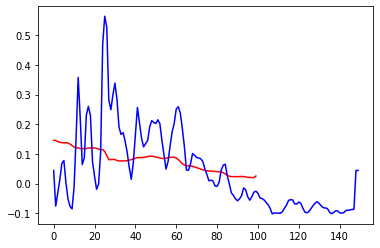

In [9]:
# Loading standard deviation data from memory
data_std = pd.read_csv('../data/std_dev_data_only.csv', names = ['id', 'x_acc', 'y_acc', 'z_acc'])
print(data_std.tail())

k = 234
m = range(100)
n = range(150)
plt.plot(m, data_std['x_acc'][k * 100 : (k + 1) * 100], 'r')
plt.plot(n, data['x_acc'][k * 150 : (k + 1) * 150], 'b')

In [10]:
# Converting labels into correct format (since size of each example has decreased after finding running standard deviation)
label_arr = labels.values
label_arr = np.argmax(label_arr, axis = 1)

y_features = np.zeros(len(data_std) // (150 - window_size))
for i in range(len(label_arr)) : 
    if i % 150 == 0 : 
        y_features[i // 150] = label_arr[i]
        
# Also converting into Pandas Series for use in extracting relevant features using tsfresh
y = pd.Series(y_features, dtype = int)

In [11]:
# Now using tsfresh to extract features
extracted_features = extract_features(data_std, column_id = "id", column_sort = None, column_kind = None, column_value = None)
print(extracted_features.shape)

Feature Extraction: 100%|██████████| 10/10 [05:17<00:00, 27.02s/it]


(1068, 2382)


In [ ]:
extracted_features = impute(extracted_features)
features_filtered = select_features(extracted_features, y)
print(features_filtered.shape)

In [13]:
print(features_filtered.shape)

(1068, 1008)


In [14]:
# Convert feature dataframes into numpy arrays (required for training in sklearn)
x_features = np.asarray(extracted_features)
print(x_features.shape)
x_features_relevant = np.asarray(features_filtered)
print(x_features_relevant.shape)
# Gives the number of examples per label
print(Counter(y_features))

(1068, 2382)
(1068, 1008)
Counter({3.0: 411, 2.0: 213, 4.0: 196, 0.0: 129, 1.0: 119})


### Shuffle and split into train/test datasets and normalize the features

In [15]:
x_train, x_test, y_f, y_test = train_test_split(x_features_relevant, y_features)
print(x_train.shape)
print(x_test.shape)
print(y_f.shape)
print(y_test.shape)
x_f = sklearn.preprocessing.minmax_scale(x_train)
x_test_norm = sklearn.preprocessing.minmax_scale(x_test)
print(Counter(y_f))

(801, 1008)
(267, 1008)
(801,)
(267,)
Counter({3.0: 309, 2.0: 157, 4.0: 147, 0.0: 98, 1.0: 90})


In [16]:
sm = SMOTE(sampling_strategy = 'not majority')
x_train_norm, y_train = sm.fit_resample(x_f, y_f)
print(Counter(y_train))
print(y_train.dtype)
y_train = y_train.astype(int)
print(y_train.dtype)
y_test = y_test.astype(int)

Counter({2.0: 309, 3.0: 309, 4.0: 309, 1.0: 309, 0.0: 309})
float64
int64


In [17]:
svm_lin = RandomForestClassifier(n_estimators = 100)
svm_lin.fit(x_train_norm, y_train)
y_pred = svm_lin.predict(x_test_norm)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train_norm)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 3  5  8 14  1]
 [ 1  8  3 14  3]
 [ 2  5 21 23  5]
 [12 13 10 53 14]
 [ 0 12  2 18 17]]
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        31
           1       0.19      0.28      0.22        29
           2       0.48      0.38      0.42        56
           3       0.43      0.52      0.47       102
           4       0.42      0.35      0.38        49

    accuracy                           0.38       267
   macro avg       0.34      0.32      0.32       267
weighted avg       0.38      0.38      0.38       267

[[309   0   0   0   0]
 [  0 309   0   0   0]
 [  0   0 306   1   2]
 [  0   2   0 306   1]
 [  0   0   0   0 309]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       309
           1       0.99      1.00      1.00       309
           2       1.00      0.99      1.00       309
           3       1.00      0.99      0.99       309
           4       0.99      1.00

In [37]:
from sklearn.decomposition import PCA

# Make an instance of the Model
pca = PCA(.99)

In [38]:
pca.fit(x_train_norm)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
train_img = pca.transform(x_train_norm)
test_img = pca.transform(x_test_norm)
print(train_img.shape)
print(test_img.shape)

(1545, 152)
(267, 152)


In [40]:
svm_lin = RandomForestClassifier(n_estimators = 100)
svm_lin.fit(train_img, y_train)
y_pred = svm_lin.predict(test_img)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(train_img)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 3  1  5 20  2]
 [ 1  4  3 14  7]
 [ 0  2 14 35  5]
 [ 3  3  7 73 16]
 [ 0  8  0 27 14]]
              precision    recall  f1-score   support

           0       0.43      0.10      0.16        31
           1       0.22      0.14      0.17        29
           2       0.48      0.25      0.33        56
           3       0.43      0.72      0.54       102
           4       0.32      0.29      0.30        49

    accuracy                           0.40       267
   macro avg       0.38      0.30      0.30       267
weighted avg       0.40      0.40      0.37       267

[[309   0   0   0   0]
 [  0 309   0   0   0]
 [  0   0 308   0   1]
 [  0   2   1 305   1]
 [  0   0   1   0 308]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       309
           1       0.99      1.00      1.00       309
           2       0.99      1.00      1.00       309
           3       1.00      0.99      0.99       309
           4       0.99      1.00